In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
    recall_score, confusion_matrix, roc_auc_score, multilabel_confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, KFold
from catboost import CatBoostClassifier
import matplotlib
import matplotlib.patches as mpatches
import joblib
import os
import pymorphy2
from tqdm import tqdm
tqdm.pandas(desc="progress:")

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/arcry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 150)

# Загрузка и предобработка данных 

In [174]:
data = pd.read_csv('../data/train_test/HeadHunter_train.csv', index_col=None,  quotechar='"')


In [199]:
test = pd.read_csv('../data/train_test/HeadHunter_test.csv', index_col=None,  quotechar='"')

In [175]:
data['review'] = data.positive + data.negative
data = data[data.review.isna() == False]
data['target_1'] = data.target.apply(lambda x: x[0])

In [200]:
test['review'] = test.positive + test.negative
na_idx = test[test.review.isna()].index
test.iloc[na_idx, 11] = 'сергей лупа пупа'

In [201]:
test.isna().sum()

review_id                  0
city                    3093
position                2227
positive                   1
negative                   3
salary_rating              0
team_rating                0
managment_rating           0
career_rating              0
workplace_rating           0
rest_recovery_rating       0
review                     0
dtype: int64

In [176]:
data = data[['review', 'target_1']]
data

review target_1
0      Недавно устроился в ****** на должность кладов...        0
1      Расположение офиса, своего рода стабильность (...        8
2      В нашем банке все по закону в плане зарплаты и...        0
3      Я в ****** около года работаю оператором. Норм...        0
4      В принципе норм.Работать можноВсегда есть к че...        8
...                                                  ...      ...
50871  Ни чего ни чего ни чего ни чегоВсё всё Всё всё...        3
50872  Есть исключительно хорошие руководители.Удачи ...        8
50873  Уютная  столовая .раздевалкаГрафик работы. Обу...        8
50874  Не соблюдают трудовой кодекс,  переработки 7 д...        1
50875  Я работаю в компании почти 2 года, платят всег...        0

[50739 rows x 2 columns]

In [179]:
data.groupby('target_1').count()

review
target_1        
0          20905
1           3117
2             12
3           1123
4             80
5            252
6            844
7            351
8          24055

In [180]:
def standardize_text(df, text_field):
    '''function for standartize sms texts'''
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace('ё', 'е', regex=True)
    df[text_field] = df[text_field].str.replace('[^A-Za-zа-яА-Я()!\ \_\n\s]', '', regex=True)
    df[text_field] = df[text_field].str.replace('(\S+\.)?\S+.((ru)|(com)|(net))(\S*)', '', regex=True)
    return df

morph = pymorphy2.MorphAnalyzer()
def normalized(text):
    return ' '.join([morph.parse(i)[0].normal_form for i in text])

In [181]:
data = standardize_text(data, 'review')

In [202]:
test = standardize_text(test, 'review')

In [182]:
# tokenize text only for embeddings
tokenizer = RegexpTokenizer(r'\w+|\S+')

data["tokens"] = data["review"].apply(tokenizer.tokenize)

data.review = data.tokens.progress_apply(normalized)

progress:: 100%|██████████| 50739/50739 [04:12<00:00, 200.62it/s]


In [203]:
# tokenize text only for embeddings
tokenizer = RegexpTokenizer(r'\w+|\S+')

test["tokens"] = test["review"].apply(tokenizer.tokenize)

test.review = test.tokens.progress_apply(normalized)

progress:: 100%|██████████| 50651/50651 [03:29<00:00, 241.88it/s]


In [185]:
data.to_parquet('../data/train_test/clean_data.pqt')

In [ ]:
test.to_parquet('../data/train_test/test_clean.pqt')

In [3]:
data = pd.read_parquet('../data/train_test/clean_data.pqt')

In [5]:
test = pd.read_parquet('../data/train_test/test_clean.pqt')

In [7]:
X = data['review']
y = data['target_1']


X_val = test['review']

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## BOW 

In [8]:
# use bag of words vectorizer method
def cv(data):
    count_vectorizer = CountVectorizer(max_features=50000, max_df=0.9, min_df=5, ngram_range=(1,3))

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [9]:
# vectorize texts
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [208]:
X_val_counts = count_vectorizer.transform(X_val)

### Log Reg

In [194]:
# use logistic regression classifier 
clf = LogisticRegression(C=0.25, 
                         multi_class='auto', random_state=40, max_iter=500)
clf.fit(X_train_counts, y_train)

LogisticRegression(C=0.25, max_iter=500, random_state=40)

In [195]:
# predict test
y_predicted_counts = clf.predict(X_test_counts)
f1_score(y_test, y_predicted_counts, average='micro')

0.7560110366574695

In [211]:
test['target'] = clf.predict(X_val_counts)
test[['review_id', 'target']].to_csv('predict_bow_log_reg.csv', index=False)

In [100]:
# X_val_counts = count_vectorizer.transform(X_val)
# res_clf = clf.predict(X_val_counts)

### GS

In [42]:
# vectorize texts
X_counts, count_vectorizer = cv(X)

In [43]:
parameters = {'solver':('newton-cg', 'lbfgs'), 'C':[0.1, 0.25, 0.5]}
lr = LogisticRegression(multi_class='auto', random_state=40, max_iter=5000)

In [44]:
kfold = KFold(shuffle=True, random_state=42)

In [45]:
clf_gs = GridSearchCV(estimator=lr, param_grid=parameters, cv=kfold, n_jobs=-1, verbose=10)

In [46]:
clf_gs.fit(X_counts, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=5000, random_state=40),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.25, 0.5],
                         'solver': ('newton-cg', 'lbfgs')},
             verbose=10)

In [47]:
clf_gs.best_estimator_

LogisticRegression(C=0.1, max_iter=5000, random_state=40, solver='newton-cg')

In [48]:
clf_gs.best_score_

0.7625692000435537

In [56]:
# predict train
y_train_pred = clf_gs.predict(X_counts)
f1_score(y, y_train_pred, average='micro')

0.8435128796389365

### SVM


In [10]:
# use SVM classifier 
clf_svc = SVC(C=0.06, probability=True, random_state=40, kernel='linear', verbose=2)
clf_svc.fit(X_train_counts, y_train)

[LibSVM]

SVC(C=0.06, kernel='linear', probability=True, random_state=40, verbose=2)

In [11]:
# predict test
y_predicted_counts_svc = clf_svc.predict(X_test_counts)
f1_score(y_test, y_predicted_counts_svc, average='micro')

0.7556957035869136

### SGD

In [18]:
# use SGD classifier 
clf_sgd = SGDClassifier(loss='log', alpha=0.0001, max_iter=2000, tol=1e-6, verbose=2, random_state=40)
clf_sgd.fit(X_train_counts, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 95.44, NNZs: 43015, Bias: -10.047901, T: 38054, Avg. loss: 3.026436
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 66.33, NNZs: 43015, Bias: -7.807845, T: 76108, Avg. loss: 0.578412
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 55.85, NNZs: 43015, Bias: -6.546445, T: 114162, Avg. loss: 0.371265
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 49.82, NNZs: 43015, Bias: -5.771083, T: 152216, Avg. loss: 0.294621
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 46.25, NNZs: 43015, Bias: -5.236217, T: 190270, Avg. loss: 0.264109
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 43.69, NNZs: 43015, Bias: -4.846406, T: 228324, Avg. loss: 0.243640
Total training time: 0.05 seconds.
-- Epoch 7
Norm: 41.83, NNZs: 43015, Bias: -4.561642, T: 266378, Avg. loss: 0.233980
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 40.33, NNZs: 43015, Bias: -4.349119, T: 304432, Avg. loss: 0.227697
Total training time: 0.07 seconds.
-- Epoch 9
Norm: 39.27, NNZs: 43015, Bias

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Norm: 37.31, NNZs: 43015, Bias: -6.439558, T: 152216, Avg. loss: 0.130089
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 34.15, NNZs: 43015, Bias: -6.152863, T: 190270, Avg. loss: 0.114037
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 32.37, NNZs: 43015, Bias: -5.921218, T: 228324, Avg. loss: 0.107167
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 30.85, NNZs: 43015, Bias: -5.746969, T: 266378, Avg. loss: 0.099681
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 29.90, NNZs: 43015, Bias: -5.595324, T: 304432, Avg. loss: 0.099224
Total training time: 0.07 seconds.
-- Epoch 9
Norm: 29.25, NNZs: 43015, Bias: -5.465095, T: 342486, Avg. loss: 0.096730
Total training time: 0.08 seconds.
-- Epoch 10
Norm: 28.60, NNZs: 43015, Bias: -5.358692, T: 380540, Avg. loss: 0.094146
Total training time: 0.09 seconds.
-- Epoch 11
Norm: 28.08, NNZs: 43015, Bias: -5.265184, T: 418594, Avg. loss: 0.093576
Total training time: 0.10 seconds.
-- Epoch 12
Norm: 27.75, NNZs: 43015, Bias: -5.17

Norm: 6.25, NNZs: 43015, Bias: -3.608818, T: 456648, Avg. loss: 0.003116
Total training time: 0.11 seconds.
-- Epoch 13
Norm: 6.21, NNZs: 43015, Bias: -3.628634, T: 494702, Avg. loss: 0.003063
Total training time: 0.12 seconds.
-- Epoch 14
Norm: 6.17, NNZs: 43015, Bias: -3.646184, T: 532756, Avg. loss: 0.003067
Total training time: 0.13 seconds.
-- Epoch 15
Norm: 6.14, NNZs: 43015, Bias: -3.662618, T: 570810, Avg. loss: 0.003021
Total training time: 0.14 seconds.
-- Epoch 16
Norm: 6.11, NNZs: 43015, Bias: -3.677852, T: 608864, Avg. loss: 0.002996
Total training time: 0.14 seconds.
-- Epoch 17
Norm: 6.08, NNZs: 43015, Bias: -3.691999, T: 646918, Avg. loss: 0.002977
Total training time: 0.15 seconds.
-- Epoch 18
Norm: 6.05, NNZs: 43015, Bias: -3.705080, T: 684972, Avg. loss: 0.002960
Total training time: 0.16 seconds.
-- Epoch 19
Norm: 6.02, NNZs: 43015, Bias: -3.717473, T: 723026, Avg. loss: 0.002940
Total training time: 0.17 seconds.
-- Epoch 20
Norm: 6.00, NNZs: 43015, Bias: -3.729160

Norm: 5.48, NNZs: 43015, Bias: -4.026429, T: 3158482, Avg. loss: 0.002524
Total training time: 0.72 seconds.
-- Epoch 84
Norm: 5.48, NNZs: 43015, Bias: -4.028721, T: 3196536, Avg. loss: 0.002521
Total training time: 0.73 seconds.
-- Epoch 85
Norm: 5.47, NNZs: 43015, Bias: -4.030985, T: 3234590, Avg. loss: 0.002518
Total training time: 0.74 seconds.
-- Epoch 86
Norm: 5.47, NNZs: 43015, Bias: -4.033232, T: 3272644, Avg. loss: 0.002514
Total training time: 0.75 seconds.
-- Epoch 87
Norm: 5.47, NNZs: 43015, Bias: -4.035441, T: 3310698, Avg. loss: 0.002512
Total training time: 0.75 seconds.
-- Epoch 88
Norm: 5.46, NNZs: 43015, Bias: -4.037618, T: 3348752, Avg. loss: 0.002510
Total training time: 0.76 seconds.
-- Epoch 89
Norm: 5.46, NNZs: 43015, Bias: -4.039772, T: 3386806, Avg. loss: 0.002507
Total training time: 0.77 seconds.
-- Epoch 90
Norm: 5.46, NNZs: 43015, Bias: -4.041901, T: 3424860, Avg. loss: 0.002505
Total training time: 0.78 seconds.
-- Epoch 91
Norm: 5.45, NNZs: 43015, Bias: -

Norm: 5.30, NNZs: 43015, Bias: -4.144721, T: 5974478, Avg. loss: 0.002387
Total training time: 1.34 seconds.
-- Epoch 158
Norm: 5.30, NNZs: 43015, Bias: -4.145860, T: 6012532, Avg. loss: 0.002386
Total training time: 1.35 seconds.
-- Epoch 159
Norm: 5.30, NNZs: 43015, Bias: -4.146989, T: 6050586, Avg. loss: 0.002384
Total training time: 1.36 seconds.
-- Epoch 160
Norm: 5.30, NNZs: 43015, Bias: -4.148110, T: 6088640, Avg. loss: 0.002383
Total training time: 1.36 seconds.
-- Epoch 161
Norm: 5.29, NNZs: 43015, Bias: -4.149224, T: 6126694, Avg. loss: 0.002382
Total training time: 1.37 seconds.
-- Epoch 162
Norm: 5.29, NNZs: 43015, Bias: -4.150332, T: 6164748, Avg. loss: 0.002381
Total training time: 1.38 seconds.
-- Epoch 163
Norm: 5.29, NNZs: 43015, Bias: -4.151431, T: 6202802, Avg. loss: 0.002380
Total training time: 1.39 seconds.
-- Epoch 164
Norm: 5.29, NNZs: 43015, Bias: -4.152524, T: 6240856, Avg. loss: 0.002378
Total training time: 1.40 seconds.
-- Epoch 165
Norm: 5.29, NNZs: 43015,

Norm: 16.01, NNZs: 43015, Bias: -1.020142, T: 266378, Avg. loss: 0.049280
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 15.81, NNZs: 43015, Bias: -1.028710, T: 304432, Avg. loss: 0.048877
Total training time: 0.07 seconds.
-- Epoch 9
Norm: 15.76, NNZs: 43015, Bias: -1.039233, T: 342486, Avg. loss: 0.048452
Total training time: 0.08 seconds.
-- Epoch 10
Norm: 15.59, NNZs: 43015, Bias: -1.041311, T: 380540, Avg. loss: 0.048366
Total training time: 0.09 seconds.
-- Epoch 11
Norm: 15.39, NNZs: 43015, Bias: -1.037592, T: 418594, Avg. loss: 0.047365
Total training time: 0.10 seconds.
-- Epoch 12
Norm: 15.39, NNZs: 43015, Bias: -1.045804, T: 456648, Avg. loss: 0.048107
Total training time: 0.10 seconds.
-- Epoch 13
Norm: 15.31, NNZs: 43015, Bias: -1.047034, T: 494702, Avg. loss: 0.047652
Total training time: 0.11 seconds.
-- Epoch 14
Norm: 15.31, NNZs: 43015, Bias: -1.051643, T: 532756, Avg. loss: 0.047708
Total training time: 0.12 seconds.
-- Epoch 15
Norm: 15.25, NNZs: 43015, Bias: -1

Norm: 7.05, NNZs: 43015, Bias: -4.886971, T: 2397402, Avg. loss: 0.005272
Total training time: 0.53 seconds.
-- Epoch 64
Norm: 7.05, NNZs: 43015, Bias: -4.888942, T: 2435456, Avg. loss: 0.005275
Total training time: 0.54 seconds.
-- Epoch 65
Norm: 7.05, NNZs: 43015, Bias: -4.890908, T: 2473510, Avg. loss: 0.005272
Total training time: 0.55 seconds.
-- Epoch 66
Norm: 7.04, NNZs: 43015, Bias: -4.892775, T: 2511564, Avg. loss: 0.005275
Total training time: 0.56 seconds.
-- Epoch 67
Norm: 7.04, NNZs: 43015, Bias: -4.894680, T: 2549618, Avg. loss: 0.005269
Total training time: 0.57 seconds.
-- Epoch 68
Norm: 7.04, NNZs: 43015, Bias: -4.896556, T: 2587672, Avg. loss: 0.005267
Total training time: 0.58 seconds.
-- Epoch 69
Norm: 7.04, NNZs: 43015, Bias: -4.898426, T: 2625726, Avg. loss: 0.005260
Total training time: 0.59 seconds.
-- Epoch 70
Norm: 7.04, NNZs: 43015, Bias: -4.900206, T: 2663780, Avg. loss: 0.005264
Total training time: 0.60 seconds.
-- Epoch 71
Norm: 7.03, NNZs: 43015, Bias: -

Norm: 24.10, NNZs: 43015, Bias: -6.658698, T: 152216, Avg. loss: 0.031836
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 22.08, NNZs: 43015, Bias: -6.604592, T: 190270, Avg. loss: 0.030065
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 20.83, NNZs: 43015, Bias: -6.556650, T: 228324, Avg. loss: 0.027845
Total training time: 0.05 seconds.
-- Epoch 7
Norm: 19.88, NNZs: 43015, Bias: -6.521100, T: 266378, Avg. loss: 0.026592
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 19.31, NNZs: 43015, Bias: -6.488656, T: 304432, Avg. loss: 0.026202
Total training time: 0.07 seconds.
-- Epoch 9
Norm: 18.82, NNZs: 43015, Bias: -6.460473, T: 342486, Avg. loss: 0.025150
Total training time: 0.07 seconds.
-- Epoch 10
Norm: 18.48, NNZs: 43015, Bias: -6.437068, T: 380540, Avg. loss: 0.024610
Total training time: 0.08 seconds.
-- Epoch 11
Norm: 18.25, NNZs: 43015, Bias: -6.414567, T: 418594, Avg. loss: 0.025058
Total training time: 0.09 seconds.
-- Epoch 12
Norm: 18.00, NNZs: 43015, Bias: -6.39

Norm: 32.24, NNZs: 43015, Bias: 1.770479, T: 761080, Avg. loss: 0.312960
Total training time: 0.18 seconds.
-- Epoch 21
Norm: 32.15, NNZs: 43015, Bias: 1.764215, T: 799134, Avg. loss: 0.312240
Total training time: 0.19 seconds.
-- Epoch 22
Norm: 32.07, NNZs: 43015, Bias: 1.757705, T: 837188, Avg. loss: 0.312639
Total training time: 0.19 seconds.
-- Epoch 23
Norm: 32.00, NNZs: 43015, Bias: 1.753691, T: 875242, Avg. loss: 0.312032
Total training time: 0.20 seconds.
-- Epoch 24
Norm: 31.96, NNZs: 43015, Bias: 1.747467, T: 913296, Avg. loss: 0.311701
Total training time: 0.21 seconds.
-- Epoch 25
Norm: 31.90, NNZs: 43015, Bias: 1.743354, T: 951350, Avg. loss: 0.311653
Total training time: 0.22 seconds.
-- Epoch 26
Norm: 31.84, NNZs: 43015, Bias: 1.740497, T: 989404, Avg. loss: 0.311389
Total training time: 0.23 seconds.
-- Epoch 27
Norm: 31.80, NNZs: 43015, Bias: 1.735644, T: 1027458, Avg. loss: 0.311133
Total training time: 0.24 seconds.
-- Epoch 28
Norm: 31.76, NNZs: 43015, Bias: 1.73291

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.2s finished


SGDClassifier(loss='log', max_iter=2000, random_state=40, tol=1e-06, verbose=2)

In [19]:
# predict test
y_predicted_counts_sgd = clf_sgd.predict(X_test_counts)
f1_score(y_test, y_predicted_counts_sgd, average='micro')

0.7594797004335829

### Catboost

In [21]:
cat = CatBoostClassifier(iterations=500,
                           depth=2,
                           learning_rate=0.5,
                           loss_function='MultiClass',
                           eval_metric='TotalF1', od_type='Iter',
                           verbose=True)
# train the model
cat.fit(X_train_counts, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5831518	total: 143ms	remaining: 1m 11s
1:	learn: 0.5831518	total: 289ms	remaining: 1m 11s
2:	learn: 0.6025020	total: 438ms	remaining: 1m 12s
3:	learn: 0.6132927	total: 581ms	remaining: 1m 11s
4:	learn: 0.6177452	total: 719ms	remaining: 1m 11s
5:	learn: 0.6259163	total: 851ms	remaining: 1m 10s
6:	learn: 0.6312036	total: 983ms	remaining: 1m 9s
7:	learn: 0.6339188	total: 1.11s	remaining: 1m 8s
8:	learn: 0.6427584	total: 1.23s	remaining: 1m 7s
9:	learn: 0.6416692	total: 1.36s	remaining: 1m 6s
10:	learn: 0.6438358	total: 1.49s	remaining: 1m 6s
11:	learn: 0.6494750	total: 1.64s	remaining: 1m 6s
12:	learn: 0.6520905	total: 1.77s	remaining: 1m 6s
13:	learn: 0.6541344	total: 1.91s	remaining: 1m 6s
14:	learn: 0.6601847	total: 2.07s	remaining: 1m 6s
15:	learn: 0.6627864	total: 2.25s	remaining: 1m 8s
16:	learn: 0.6646232	total: 2.48s	remaining: 1m 10s
17:	learn: 0.6661468	total: 2.69s	remaining: 1m 11s
18:	learn: 0.6675572	total: 2.9s	remaining: 1m 13s
19:	learn: 0.6684916	total: 3.1s	

159:	learn: 0.7266570	total: 30.9s	remaining: 1m 5s
160:	learn: 0.7266278	total: 31.1s	remaining: 1m 5s
161:	learn: 0.7266369	total: 31.3s	remaining: 1m 5s
162:	learn: 0.7266618	total: 31.5s	remaining: 1m 5s
163:	learn: 0.7267189	total: 31.7s	remaining: 1m 4s
164:	learn: 0.7266292	total: 31.9s	remaining: 1m 4s
165:	learn: 0.7267461	total: 32.1s	remaining: 1m 4s
166:	learn: 0.7267218	total: 32.2s	remaining: 1m 4s
167:	learn: 0.7267245	total: 32.4s	remaining: 1m 4s
168:	learn: 0.7267991	total: 32.6s	remaining: 1m 3s
169:	learn: 0.7267853	total: 32.8s	remaining: 1m 3s
170:	learn: 0.7267991	total: 33s	remaining: 1m 3s
171:	learn: 0.7268139	total: 33.2s	remaining: 1m 3s
172:	learn: 0.7267382	total: 33.4s	remaining: 1m 3s
173:	learn: 0.7267836	total: 33.6s	remaining: 1m 2s
174:	learn: 0.7269082	total: 33.8s	remaining: 1m 2s
175:	learn: 0.7269214	total: 34s	remaining: 1m 2s
176:	learn: 0.7269711	total: 34.2s	remaining: 1m 2s
177:	learn: 0.7269735	total: 34.4s	remaining: 1m 2s
178:	learn: 0.72

319:	learn: 0.7337617	total: 1m 1s	remaining: 34.8s
320:	learn: 0.7337363	total: 1m 2s	remaining: 34.6s
321:	learn: 0.7338264	total: 1m 2s	remaining: 34.4s
322:	learn: 0.7339428	total: 1m 2s	remaining: 34.2s
323:	learn: 0.7339037	total: 1m 2s	remaining: 34s
324:	learn: 0.7339298	total: 1m 2s	remaining: 33.8s
325:	learn: 0.7340073	total: 1m 2s	remaining: 33.6s
326:	learn: 0.7341561	total: 1m 3s	remaining: 33.4s
327:	learn: 0.7341650	total: 1m 3s	remaining: 33.2s
328:	learn: 0.7342682	total: 1m 3s	remaining: 33s
329:	learn: 0.7342917	total: 1m 3s	remaining: 32.8s
330:	learn: 0.7342901	total: 1m 3s	remaining: 32.6s
331:	learn: 0.7343258	total: 1m 4s	remaining: 32.4s
332:	learn: 0.7343184	total: 1m 4s	remaining: 32.2s
333:	learn: 0.7345986	total: 1m 4s	remaining: 32.1s
334:	learn: 0.7346128	total: 1m 4s	remaining: 31.9s
335:	learn: 0.7346836	total: 1m 4s	remaining: 31.7s
336:	learn: 0.7346587	total: 1m 5s	remaining: 31.5s
337:	learn: 0.7346445	total: 1m 5s	remaining: 31.3s
338:	learn: 0.73

475:	learn: 0.7388075	total: 1m 32s	remaining: 4.64s
476:	learn: 0.7389029	total: 1m 32s	remaining: 4.45s
477:	learn: 0.7389029	total: 1m 32s	remaining: 4.25s
478:	learn: 0.7389029	total: 1m 32s	remaining: 4.06s
479:	learn: 0.7389505	total: 1m 32s	remaining: 3.87s
480:	learn: 0.7389907	total: 1m 32s	remaining: 3.67s
481:	learn: 0.7389734	total: 1m 33s	remaining: 3.48s
482:	learn: 0.7389907	total: 1m 33s	remaining: 3.29s
483:	learn: 0.7390576	total: 1m 33s	remaining: 3.09s
484:	learn: 0.7390761	total: 1m 33s	remaining: 2.9s
485:	learn: 0.7390412	total: 1m 33s	remaining: 2.71s
486:	learn: 0.7392329	total: 1m 34s	remaining: 2.51s
487:	learn: 0.7392068	total: 1m 34s	remaining: 2.32s
488:	learn: 0.7392437	total: 1m 34s	remaining: 2.13s
489:	learn: 0.7392104	total: 1m 34s	remaining: 1.93s
490:	learn: 0.7392104	total: 1m 34s	remaining: 1.74s
491:	learn: 0.7392104	total: 1m 35s	remaining: 1.55s
492:	learn: 0.7393044	total: 1m 35s	remaining: 1.35s
493:	learn: 0.7393293	total: 1m 35s	remaining: 

In [22]:
# predict test
y_predicted_counts_cat = cat.predict(X_test_counts)
f1_score(y_test, y_predicted_counts_cat, average='micro')

0.7400867165944027

## TF-IDF

In [226]:
# use tfidf vectorizer method
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(max_features=50000, max_df=0.9, min_df=5, ngram_range=(1,3))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


In [227]:
# vectorize train and test features
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [234]:
X_val_tfidf = tfidf_vectorizer.transform(X_val)

### Log Reg

In [65]:
# use logistic regression classifier 
clf_tfidf = LogisticRegression(C=10, 
                         multi_class='auto', random_state=40, max_iter=500)
clf_tfidf.fit(X_train_tfidf, y_train)

# predict
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
y_train_pred = clf_tfidf.predict(X_train_tfidf)

/home/arcry/envmetr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
# test
f1_score(y_test, y_predicted_tfidf, average='micro')

0.7423728813559322

In [159]:
# train
multiclass_roc_auc_score(y_train, y_train_pred)

1.0

### Catboost 

In [231]:
cat_tfidf = CatBoostClassifier(iterations=3000,
                           depth=2,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           eval_metric='TotalF1', od_type='Iter',
                           verbose=True)
# train the model
cat_tfidf.fit(X_train_tfidf, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5920826	total: 208ms	remaining: 10m 23s
1:	learn: 0.6068577	total: 438ms	remaining: 10m 56s
2:	learn: 0.5990508	total: 752ms	remaining: 12m 31s
3:	learn: 0.6093563	total: 1.16s	remaining: 14m 27s
4:	learn: 0.6145344	total: 1.54s	remaining: 15m 21s
5:	learn: 0.6143665	total: 1.94s	remaining: 16m 10s
6:	learn: 0.6169499	total: 2.34s	remaining: 16m 42s
7:	learn: 0.6253957	total: 2.75s	remaining: 17m 10s
8:	learn: 0.6277658	total: 3.17s	remaining: 17m 31s
9:	learn: 0.6295399	total: 3.52s	remaining: 17m 32s
10:	learn: 0.6315603	total: 3.88s	remaining: 17m 35s
11:	learn: 0.6313396	total: 4.3s	remaining: 17m 49s
12:	learn: 0.6321421	total: 4.68s	remaining: 17m 56s
13:	learn: 0.6344875	total: 5.08s	remaining: 18m 2s
14:	learn: 0.6353894	total: 5.44s	remaining: 18m 2s
15:	learn: 0.6351862	total: 5.8s	remaining: 18m 2s
16:	learn: 0.6364423	total: 6.15s	remaining: 17m 59s
17:	learn: 0.6374110	total: 6.52s	remaining: 18m
18:	learn: 0.6379329	total: 6.87s	remaining: 17m 57s
19:	learn: 0

155:	learn: 0.6861669	total: 50.9s	remaining: 15m 28s
156:	learn: 0.6864420	total: 51.2s	remaining: 15m 27s
157:	learn: 0.6865983	total: 51.5s	remaining: 15m 26s
158:	learn: 0.6865349	total: 51.8s	remaining: 15m 25s
159:	learn: 0.6867583	total: 52.1s	remaining: 15m 24s
160:	learn: 0.6868421	total: 52.4s	remaining: 15m 24s
161:	learn: 0.6871969	total: 52.7s	remaining: 15m 23s
162:	learn: 0.6877278	total: 53s	remaining: 15m 23s
163:	learn: 0.6880885	total: 53.3s	remaining: 15m 22s
164:	learn: 0.6881429	total: 53.6s	remaining: 15m 21s
165:	learn: 0.6882528	total: 53.9s	remaining: 15m 21s
166:	learn: 0.6884270	total: 54.2s	remaining: 15m 20s
167:	learn: 0.6886006	total: 54.5s	remaining: 15m 19s
168:	learn: 0.6887701	total: 54.8s	remaining: 15m 18s
169:	learn: 0.6888249	total: 55.2s	remaining: 15m 18s
170:	learn: 0.6889601	total: 55.5s	remaining: 15m 17s
171:	learn: 0.6889618	total: 55.8s	remaining: 15m 16s
172:	learn: 0.6891599	total: 56.1s	remaining: 15m 15s
173:	learn: 0.6892327	total: 5

306:	learn: 0.7035703	total: 1m 36s	remaining: 14m 10s
307:	learn: 0.7035703	total: 1m 37s	remaining: 14m 9s
308:	learn: 0.7038273	total: 1m 37s	remaining: 14m 9s
309:	learn: 0.7038311	total: 1m 37s	remaining: 14m 8s
310:	learn: 0.7038320	total: 1m 38s	remaining: 14m 8s
311:	learn: 0.7040531	total: 1m 38s	remaining: 14m 7s
312:	learn: 0.7040286	total: 1m 38s	remaining: 14m 7s
313:	learn: 0.7039510	total: 1m 39s	remaining: 14m 6s
314:	learn: 0.7038709	total: 1m 39s	remaining: 14m 6s
315:	learn: 0.7040752	total: 1m 39s	remaining: 14m 5s
316:	learn: 0.7041681	total: 1m 39s	remaining: 14m 5s
317:	learn: 0.7042754	total: 1m 40s	remaining: 14m 5s
318:	learn: 0.7044125	total: 1m 40s	remaining: 14m 4s
319:	learn: 0.7044125	total: 1m 40s	remaining: 14m 4s
320:	learn: 0.7045734	total: 1m 41s	remaining: 14m 4s
321:	learn: 0.7045998	total: 1m 41s	remaining: 14m 3s
322:	learn: 0.7047294	total: 1m 41s	remaining: 14m 3s
323:	learn: 0.7049649	total: 1m 42s	remaining: 14m 2s
324:	learn: 0.7049894	total

457:	learn: 0.7119335	total: 2m 22s	remaining: 13m 8s
458:	learn: 0.7120016	total: 2m 22s	remaining: 13m 7s
459:	learn: 0.7120050	total: 2m 22s	remaining: 13m 7s
460:	learn: 0.7121040	total: 2m 22s	remaining: 13m 7s
461:	learn: 0.7121499	total: 2m 23s	remaining: 13m 6s
462:	learn: 0.7120995	total: 2m 23s	remaining: 13m 6s
463:	learn: 0.7121468	total: 2m 23s	remaining: 13m 5s
464:	learn: 0.7123266	total: 2m 24s	remaining: 13m 5s
465:	learn: 0.7125090	total: 2m 24s	remaining: 13m 5s
466:	learn: 0.7125172	total: 2m 24s	remaining: 13m 4s
467:	learn: 0.7125172	total: 2m 25s	remaining: 13m 4s
468:	learn: 0.7124695	total: 2m 25s	remaining: 13m 4s
469:	learn: 0.7124178	total: 2m 25s	remaining: 13m 3s
470:	learn: 0.7125226	total: 2m 25s	remaining: 13m 3s
471:	learn: 0.7125745	total: 2m 26s	remaining: 13m 3s
472:	learn: 0.7125499	total: 2m 26s	remaining: 13m 2s
473:	learn: 0.7126621	total: 2m 26s	remaining: 13m 2s
474:	learn: 0.7129013	total: 2m 27s	remaining: 13m 2s
475:	learn: 0.7127630	total:

608:	learn: 0.7181834	total: 3m 7s	remaining: 12m 16s
609:	learn: 0.7182045	total: 3m 7s	remaining: 12m 15s
610:	learn: 0.7182603	total: 3m 8s	remaining: 12m 15s
611:	learn: 0.7183045	total: 3m 8s	remaining: 12m 15s
612:	learn: 0.7183453	total: 3m 8s	remaining: 12m 14s
613:	learn: 0.7182957	total: 3m 8s	remaining: 12m 14s
614:	learn: 0.7185807	total: 3m 9s	remaining: 12m 14s
615:	learn: 0.7185807	total: 3m 9s	remaining: 12m 13s
616:	learn: 0.7184923	total: 3m 9s	remaining: 12m 13s
617:	learn: 0.7184923	total: 3m 10s	remaining: 12m 12s
618:	learn: 0.7184923	total: 3m 10s	remaining: 12m 12s
619:	learn: 0.7184923	total: 3m 10s	remaining: 12m 12s
620:	learn: 0.7185181	total: 3m 11s	remaining: 12m 11s
621:	learn: 0.7185447	total: 3m 11s	remaining: 12m 11s
622:	learn: 0.7186715	total: 3m 11s	remaining: 12m 11s
623:	learn: 0.7186443	total: 3m 11s	remaining: 12m 10s
624:	learn: 0.7186203	total: 3m 12s	remaining: 12m 10s
625:	learn: 0.7186715	total: 3m 12s	remaining: 12m 10s
626:	learn: 0.71866

758:	learn: 0.7228661	total: 3m 52s	remaining: 11m 26s
759:	learn: 0.7228646	total: 3m 52s	remaining: 11m 26s
760:	learn: 0.7228646	total: 3m 53s	remaining: 11m 25s
761:	learn: 0.7229618	total: 3m 53s	remaining: 11m 25s
762:	learn: 0.7229618	total: 3m 53s	remaining: 11m 25s
763:	learn: 0.7229618	total: 3m 53s	remaining: 11m 24s
764:	learn: 0.7229163	total: 3m 54s	remaining: 11m 24s
765:	learn: 0.7228965	total: 3m 54s	remaining: 11m 24s
766:	learn: 0.7229202	total: 3m 54s	remaining: 11m 23s
767:	learn: 0.7229202	total: 3m 55s	remaining: 11m 23s
768:	learn: 0.7229202	total: 3m 55s	remaining: 11m 23s
769:	learn: 0.7229449	total: 3m 55s	remaining: 11m 22s
770:	learn: 0.7230763	total: 3m 56s	remaining: 11m 22s
771:	learn: 0.7231384	total: 3m 56s	remaining: 11m 22s
772:	learn: 0.7231384	total: 3m 56s	remaining: 11m 21s
773:	learn: 0.7232862	total: 3m 56s	remaining: 11m 21s
774:	learn: 0.7232862	total: 3m 57s	remaining: 11m 21s
775:	learn: 0.7232862	total: 3m 57s	remaining: 11m 20s
776:	learn

909:	learn: 0.7252501	total: 4m 37s	remaining: 10m 37s
910:	learn: 0.7252949	total: 4m 37s	remaining: 10m 37s
911:	learn: 0.7252980	total: 4m 38s	remaining: 10m 36s
912:	learn: 0.7252125	total: 4m 38s	remaining: 10m 36s
913:	learn: 0.7252331	total: 4m 38s	remaining: 10m 36s
914:	learn: 0.7252331	total: 4m 39s	remaining: 10m 35s
915:	learn: 0.7252278	total: 4m 39s	remaining: 10m 35s
916:	learn: 0.7252826	total: 4m 39s	remaining: 10m 35s
917:	learn: 0.7252461	total: 4m 39s	remaining: 10m 34s
918:	learn: 0.7252461	total: 4m 40s	remaining: 10m 34s
919:	learn: 0.7252447	total: 4m 40s	remaining: 10m 34s
920:	learn: 0.7253128	total: 4m 40s	remaining: 10m 33s
921:	learn: 0.7253150	total: 4m 41s	remaining: 10m 33s
922:	learn: 0.7255114	total: 4m 41s	remaining: 10m 33s
923:	learn: 0.7254881	total: 4m 41s	remaining: 10m 32s
924:	learn: 0.7254892	total: 4m 41s	remaining: 10m 32s
925:	learn: 0.7256093	total: 4m 42s	remaining: 10m 32s
926:	learn: 0.7256093	total: 4m 42s	remaining: 10m 31s
927:	learn

1059:	learn: 0.7279580	total: 5m 22s	remaining: 9m 49s
1060:	learn: 0.7279580	total: 5m 22s	remaining: 9m 49s
1061:	learn: 0.7279580	total: 5m 22s	remaining: 9m 49s
1062:	learn: 0.7279580	total: 5m 23s	remaining: 9m 48s
1063:	learn: 0.7279580	total: 5m 23s	remaining: 9m 48s
1064:	learn: 0.7279580	total: 5m 23s	remaining: 9m 48s
1065:	learn: 0.7279580	total: 5m 24s	remaining: 9m 48s
1066:	learn: 0.7279580	total: 5m 24s	remaining: 9m 47s
1067:	learn: 0.7279580	total: 5m 24s	remaining: 9m 47s
1068:	learn: 0.7279838	total: 5m 24s	remaining: 9m 47s
1069:	learn: 0.7280046	total: 5m 25s	remaining: 9m 46s
1070:	learn: 0.7280046	total: 5m 25s	remaining: 9m 46s
1071:	learn: 0.7279788	total: 5m 25s	remaining: 9m 46s
1072:	learn: 0.7280315	total: 5m 26s	remaining: 9m 45s
1073:	learn: 0.7280329	total: 5m 26s	remaining: 9m 45s
1074:	learn: 0.7279875	total: 5m 26s	remaining: 9m 45s
1075:	learn: 0.7280083	total: 5m 27s	remaining: 9m 44s
1076:	learn: 0.7280083	total: 5m 27s	remaining: 9m 44s
1077:	lear

1209:	learn: 0.7304620	total: 6m 7s	remaining: 9m 3s
1210:	learn: 0.7304620	total: 6m 7s	remaining: 9m 3s
1211:	learn: 0.7305085	total: 6m 8s	remaining: 9m 2s
1212:	learn: 0.7305587	total: 6m 8s	remaining: 9m 2s
1213:	learn: 0.7306183	total: 6m 8s	remaining: 9m 2s
1214:	learn: 0.7306236	total: 6m 8s	remaining: 9m 2s
1215:	learn: 0.7306236	total: 6m 9s	remaining: 9m 1s
1216:	learn: 0.7306236	total: 6m 9s	remaining: 9m 1s
1217:	learn: 0.7306742	total: 6m 9s	remaining: 9m 1s
1218:	learn: 0.7306742	total: 6m 10s	remaining: 9m
1219:	learn: 0.7306715	total: 6m 10s	remaining: 9m
1220:	learn: 0.7306715	total: 6m 10s	remaining: 9m
1221:	learn: 0.7306715	total: 6m 11s	remaining: 8m 59s
1222:	learn: 0.7307475	total: 6m 11s	remaining: 8m 59s
1223:	learn: 0.7307475	total: 6m 11s	remaining: 8m 59s
1224:	learn: 0.7307733	total: 6m 11s	remaining: 8m 58s
1225:	learn: 0.7307733	total: 6m 12s	remaining: 8m 58s
1226:	learn: 0.7307733	total: 6m 12s	remaining: 8m 58s
1227:	learn: 0.7308405	total: 6m 12s	rem

1359:	learn: 0.7326952	total: 6m 52s	remaining: 8m 17s
1360:	learn: 0.7327410	total: 6m 52s	remaining: 8m 17s
1361:	learn: 0.7327410	total: 6m 53s	remaining: 8m 16s
1362:	learn: 0.7327658	total: 6m 53s	remaining: 8m 16s
1363:	learn: 0.7327877	total: 6m 53s	remaining: 8m 16s
1364:	learn: 0.7327877	total: 6m 54s	remaining: 8m 15s
1365:	learn: 0.7327625	total: 6m 54s	remaining: 8m 15s
1366:	learn: 0.7327625	total: 6m 54s	remaining: 8m 15s
1367:	learn: 0.7329430	total: 6m 54s	remaining: 8m 15s
1368:	learn: 0.7329946	total: 6m 55s	remaining: 8m 14s
1369:	learn: 0.7329946	total: 6m 55s	remaining: 8m 14s
1370:	learn: 0.7329946	total: 6m 55s	remaining: 8m 14s
1371:	learn: 0.7330452	total: 6m 56s	remaining: 8m 13s
1372:	learn: 0.7330710	total: 6m 56s	remaining: 8m 13s
1373:	learn: 0.7330710	total: 6m 56s	remaining: 8m 13s
1374:	learn: 0.7330968	total: 6m 57s	remaining: 8m 12s
1375:	learn: 0.7331240	total: 6m 57s	remaining: 8m 12s
1376:	learn: 0.7331240	total: 6m 57s	remaining: 8m 12s
1377:	lear

1510:	learn: 0.7350931	total: 7m 37s	remaining: 7m 30s
1511:	learn: 0.7351180	total: 7m 37s	remaining: 7m 30s
1512:	learn: 0.7351596	total: 7m 38s	remaining: 7m 30s
1513:	learn: 0.7351596	total: 7m 38s	remaining: 7m 29s
1514:	learn: 0.7351596	total: 7m 38s	remaining: 7m 29s
1515:	learn: 0.7351338	total: 7m 38s	remaining: 7m 29s
1516:	learn: 0.7351338	total: 7m 39s	remaining: 7m 28s
1517:	learn: 0.7351489	total: 7m 39s	remaining: 7m 28s
1518:	learn: 0.7351489	total: 7m 39s	remaining: 7m 28s
1519:	learn: 0.7351489	total: 7m 40s	remaining: 7m 28s
1520:	learn: 0.7350695	total: 7m 40s	remaining: 7m 27s
1521:	learn: 0.7350279	total: 7m 40s	remaining: 7m 27s
1522:	learn: 0.7350289	total: 7m 41s	remaining: 7m 27s
1523:	learn: 0.7350537	total: 7m 41s	remaining: 7m 26s
1524:	learn: 0.7350995	total: 7m 41s	remaining: 7m 26s
1525:	learn: 0.7350995	total: 7m 41s	remaining: 7m 26s
1526:	learn: 0.7351407	total: 7m 42s	remaining: 7m 25s
1527:	learn: 0.7351394	total: 7m 42s	remaining: 7m 25s
1528:	lear

1661:	learn: 0.7358144	total: 8m 22s	remaining: 6m 44s
1662:	learn: 0.7358144	total: 8m 23s	remaining: 6m 44s
1663:	learn: 0.7358144	total: 8m 23s	remaining: 6m 44s
1664:	learn: 0.7358144	total: 8m 23s	remaining: 6m 43s
1665:	learn: 0.7358144	total: 8m 24s	remaining: 6m 43s
1666:	learn: 0.7358144	total: 8m 24s	remaining: 6m 43s
1667:	learn: 0.7358144	total: 8m 24s	remaining: 6m 43s
1668:	learn: 0.7357404	total: 8m 25s	remaining: 6m 42s
1669:	learn: 0.7357404	total: 8m 25s	remaining: 6m 42s
1670:	learn: 0.7356887	total: 8m 25s	remaining: 6m 42s
1671:	learn: 0.7357145	total: 8m 26s	remaining: 6m 41s
1672:	learn: 0.7357145	total: 8m 26s	remaining: 6m 41s
1673:	learn: 0.7356897	total: 8m 26s	remaining: 6m 41s
1674:	learn: 0.7357015	total: 8m 26s	remaining: 6m 41s
1675:	learn: 0.7357015	total: 8m 27s	remaining: 6m 40s
1676:	learn: 0.7357015	total: 8m 27s	remaining: 6m 40s
1677:	learn: 0.7357531	total: 8m 27s	remaining: 6m 40s
1678:	learn: 0.7357485	total: 8m 28s	remaining: 6m 39s
1679:	lear

1812:	learn: 0.7368075	total: 9m 8s	remaining: 5m 58s
1813:	learn: 0.7368075	total: 9m 8s	remaining: 5m 58s
1814:	learn: 0.7368488	total: 9m 8s	remaining: 5m 58s
1815:	learn: 0.7368498	total: 9m 9s	remaining: 5m 58s
1816:	learn: 0.7368333	total: 9m 9s	remaining: 5m 57s
1817:	learn: 0.7368333	total: 9m 9s	remaining: 5m 57s
1818:	learn: 0.7369189	total: 9m 10s	remaining: 5m 57s
1819:	learn: 0.7369189	total: 9m 10s	remaining: 5m 56s
1820:	learn: 0.7369189	total: 9m 10s	remaining: 5m 56s
1821:	learn: 0.7369489	total: 9m 10s	remaining: 5m 56s
1822:	learn: 0.7370109	total: 9m 11s	remaining: 5m 55s
1823:	learn: 0.7369996	total: 9m 11s	remaining: 5m 55s
1824:	learn: 0.7369996	total: 9m 11s	remaining: 5m 55s
1825:	learn: 0.7370493	total: 9m 12s	remaining: 5m 55s
1826:	learn: 0.7370493	total: 9m 12s	remaining: 5m 54s
1827:	learn: 0.7370493	total: 9m 12s	remaining: 5m 54s
1828:	learn: 0.7370244	total: 9m 13s	remaining: 5m 54s
1829:	learn: 0.7370493	total: 9m 13s	remaining: 5m 53s
1830:	learn: 0.7

1962:	learn: 0.7382166	total: 9m 53s	remaining: 5m 13s
1963:	learn: 0.7382414	total: 9m 53s	remaining: 5m 13s
1964:	learn: 0.7382166	total: 9m 54s	remaining: 5m 12s
1965:	learn: 0.7382166	total: 9m 54s	remaining: 5m 12s
1966:	learn: 0.7382166	total: 9m 54s	remaining: 5m 12s
1967:	learn: 0.7382524	total: 9m 54s	remaining: 5m 11s
1968:	learn: 0.7383206	total: 9m 55s	remaining: 5m 11s
1969:	learn: 0.7383206	total: 9m 55s	remaining: 5m 11s
1970:	learn: 0.7383206	total: 9m 55s	remaining: 5m 11s
1971:	learn: 0.7382782	total: 9m 56s	remaining: 5m 10s
1972:	learn: 0.7382782	total: 9m 56s	remaining: 5m 10s
1973:	learn: 0.7383196	total: 9m 56s	remaining: 5m 10s
1974:	learn: 0.7383196	total: 9m 57s	remaining: 5m 9s
1975:	learn: 0.7383196	total: 9m 57s	remaining: 5m 9s
1976:	learn: 0.7382772	total: 9m 57s	remaining: 5m 9s
1977:	learn: 0.7382772	total: 9m 57s	remaining: 5m 8s
1978:	learn: 0.7382772	total: 9m 58s	remaining: 5m 8s
1979:	learn: 0.7382772	total: 9m 58s	remaining: 5m 8s
1980:	learn: 0.7

2111:	learn: 0.7391863	total: 10m 38s	remaining: 4m 28s
2112:	learn: 0.7391863	total: 10m 38s	remaining: 4m 28s
2113:	learn: 0.7391863	total: 10m 39s	remaining: 4m 27s
2114:	learn: 0.7391863	total: 10m 39s	remaining: 4m 27s
2115:	learn: 0.7392013	total: 10m 39s	remaining: 4m 27s
2116:	learn: 0.7392013	total: 10m 39s	remaining: 4m 26s
2117:	learn: 0.7392262	total: 10m 40s	remaining: 4m 26s
2118:	learn: 0.7391854	total: 10m 40s	remaining: 4m 26s
2119:	learn: 0.7391596	total: 10m 40s	remaining: 4m 26s
2120:	learn: 0.7391400	total: 10m 41s	remaining: 4m 25s
2121:	learn: 0.7392103	total: 10m 41s	remaining: 4m 25s
2122:	learn: 0.7391854	total: 10m 41s	remaining: 4m 25s
2123:	learn: 0.7392510	total: 10m 42s	remaining: 4m 24s
2124:	learn: 0.7392103	total: 10m 42s	remaining: 4m 24s
2125:	learn: 0.7392103	total: 10m 42s	remaining: 4m 24s
2126:	learn: 0.7392103	total: 10m 42s	remaining: 4m 23s
2127:	learn: 0.7392351	total: 10m 43s	remaining: 4m 23s
2128:	learn: 0.7392372	total: 10m 43s	remaining:

2259:	learn: 0.7401965	total: 11m 23s	remaining: 3m 43s
2260:	learn: 0.7401965	total: 11m 23s	remaining: 3m 43s
2261:	learn: 0.7401965	total: 11m 24s	remaining: 3m 43s
2262:	learn: 0.7402645	total: 11m 24s	remaining: 3m 42s
2263:	learn: 0.7402645	total: 11m 24s	remaining: 3m 42s
2264:	learn: 0.7402979	total: 11m 24s	remaining: 3m 42s
2265:	learn: 0.7402721	total: 11m 25s	remaining: 3m 41s
2266:	learn: 0.7404860	total: 11m 25s	remaining: 3m 41s
2267:	learn: 0.7404860	total: 11m 25s	remaining: 3m 41s
2268:	learn: 0.7404860	total: 11m 26s	remaining: 3m 41s
2269:	learn: 0.7405921	total: 11m 26s	remaining: 3m 40s
2270:	learn: 0.7406179	total: 11m 26s	remaining: 3m 40s
2271:	learn: 0.7406179	total: 11m 27s	remaining: 3m 40s
2272:	learn: 0.7406160	total: 11m 27s	remaining: 3m 39s
2273:	learn: 0.7404947	total: 11m 27s	remaining: 3m 39s
2274:	learn: 0.7405205	total: 11m 28s	remaining: 3m 39s
2275:	learn: 0.7405611	total: 11m 28s	remaining: 3m 38s
2276:	learn: 0.7406266	total: 11m 28s	remaining:

2407:	learn: 0.7418899	total: 12m 7s	remaining: 2m 58s
2408:	learn: 0.7419157	total: 12m 8s	remaining: 2m 58s
2409:	learn: 0.7418899	total: 12m 8s	remaining: 2m 58s
2410:	learn: 0.7418899	total: 12m 8s	remaining: 2m 58s
2411:	learn: 0.7419157	total: 12m 9s	remaining: 2m 57s
2412:	learn: 0.7419157	total: 12m 9s	remaining: 2m 57s
2413:	learn: 0.7419157	total: 12m 9s	remaining: 2m 57s
2414:	learn: 0.7419157	total: 12m 10s	remaining: 2m 56s
2415:	learn: 0.7419157	total: 12m 10s	remaining: 2m 56s
2416:	learn: 0.7419157	total: 12m 10s	remaining: 2m 56s
2417:	learn: 0.7419415	total: 12m 10s	remaining: 2m 55s
2418:	learn: 0.7419415	total: 12m 11s	remaining: 2m 55s
2419:	learn: 0.7419415	total: 12m 11s	remaining: 2m 55s
2420:	learn: 0.7419415	total: 12m 11s	remaining: 2m 55s
2421:	learn: 0.7419415	total: 12m 12s	remaining: 2m 54s
2422:	learn: 0.7419415	total: 12m 12s	remaining: 2m 54s
2423:	learn: 0.7419415	total: 12m 12s	remaining: 2m 54s
2424:	learn: 0.7419166	total: 12m 13s	remaining: 2m 53s

2554:	learn: 0.7426126	total: 12m 53s	remaining: 2m 14s
2555:	learn: 0.7426126	total: 12m 54s	remaining: 2m 14s
2556:	learn: 0.7426126	total: 12m 54s	remaining: 2m 14s
2557:	learn: 0.7426126	total: 12m 54s	remaining: 2m 13s
2558:	learn: 0.7426126	total: 12m 55s	remaining: 2m 13s
2559:	learn: 0.7426384	total: 12m 55s	remaining: 2m 13s
2560:	learn: 0.7426384	total: 12m 55s	remaining: 2m 12s
2561:	learn: 0.7426384	total: 12m 55s	remaining: 2m 12s
2562:	learn: 0.7426384	total: 12m 56s	remaining: 2m 12s
2563:	learn: 0.7425935	total: 12m 56s	remaining: 2m 12s
2564:	learn: 0.7425935	total: 12m 56s	remaining: 2m 11s
2565:	learn: 0.7426184	total: 12m 57s	remaining: 2m 11s
2566:	learn: 0.7426184	total: 12m 57s	remaining: 2m 11s
2567:	learn: 0.7426203	total: 12m 57s	remaining: 2m 10s
2568:	learn: 0.7426203	total: 12m 57s	remaining: 2m 10s
2569:	learn: 0.7427024	total: 12m 58s	remaining: 2m 10s
2570:	learn: 0.7426775	total: 12m 58s	remaining: 2m 9s
2571:	learn: 0.7426775	total: 12m 58s	remaining: 

2702:	learn: 0.7435977	total: 13m 39s	remaining: 1m 30s
2703:	learn: 0.7435977	total: 13m 39s	remaining: 1m 29s
2704:	learn: 0.7435977	total: 13m 40s	remaining: 1m 29s
2705:	learn: 0.7435977	total: 13m 40s	remaining: 1m 29s
2706:	learn: 0.7436235	total: 13m 40s	remaining: 1m 28s
2707:	learn: 0.7436493	total: 13m 41s	remaining: 1m 28s
2708:	learn: 0.7436493	total: 13m 41s	remaining: 1m 28s
2709:	learn: 0.7436493	total: 13m 41s	remaining: 1m 27s
2710:	learn: 0.7436493	total: 13m 42s	remaining: 1m 27s
2711:	learn: 0.7436493	total: 13m 42s	remaining: 1m 27s
2712:	learn: 0.7436493	total: 13m 42s	remaining: 1m 27s
2713:	learn: 0.7436493	total: 13m 42s	remaining: 1m 26s
2714:	learn: 0.7436493	total: 13m 43s	remaining: 1m 26s
2715:	learn: 0.7436493	total: 13m 43s	remaining: 1m 26s
2716:	learn: 0.7436957	total: 13m 43s	remaining: 1m 25s
2717:	learn: 0.7436957	total: 13m 44s	remaining: 1m 25s
2718:	learn: 0.7436957	total: 13m 44s	remaining: 1m 25s
2719:	learn: 0.7436957	total: 13m 44s	remaining:

2851:	learn: 0.7447945	total: 14m 29s	remaining: 45.1s
2852:	learn: 0.7447937	total: 14m 29s	remaining: 44.8s
2853:	learn: 0.7447937	total: 14m 29s	remaining: 44.5s
2854:	learn: 0.7448337	total: 14m 29s	remaining: 44.2s
2855:	learn: 0.7448337	total: 14m 30s	remaining: 43.9s
2856:	learn: 0.7448346	total: 14m 30s	remaining: 43.6s
2857:	learn: 0.7448346	total: 14m 30s	remaining: 43.3s
2858:	learn: 0.7448346	total: 14m 31s	remaining: 43s
2859:	learn: 0.7448346	total: 14m 31s	remaining: 42.7s
2860:	learn: 0.7448346	total: 14m 31s	remaining: 42.4s
2861:	learn: 0.7448346	total: 14m 32s	remaining: 42.1s
2862:	learn: 0.7448346	total: 14m 32s	remaining: 41.7s
2863:	learn: 0.7448346	total: 14m 32s	remaining: 41.4s
2864:	learn: 0.7448346	total: 14m 33s	remaining: 41.1s
2865:	learn: 0.7448346	total: 14m 33s	remaining: 40.8s
2866:	learn: 0.7448253	total: 14m 33s	remaining: 40.5s
2867:	learn: 0.7448253	total: 14m 33s	remaining: 40.2s
2868:	learn: 0.7448697	total: 14m 34s	remaining: 39.9s
2869:	learn:

In [232]:
# predict test
y_predicted_counts_cat = cat_tfidf.predict(X_test_tfidf)
f1_score(y_test, y_predicted_counts_cat, average='micro')

0.7486795427670477

## Word2Vec

In [78]:
X_w = data['tokens']
y_w = data['target_1']


test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X_w, y_w, test_size=0.25, random_state=42)

In [81]:
# use Word2Vec
model = word2vec.Word2Vec(X_train, vector_size=300, window=2, workers=4)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [82]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [83]:
# create embeddings 
X_train_word2vec = get_word2vec_embeddings(w2v, X_train)
y_train_word2vec = y_train

X_test_word2vec = get_word2vec_embeddings(w2v, X_test)
y_test_word2vec = y_test


### Log Reg

In [86]:
# use logistic regression classifier
clf_w2v = LogisticRegression(C=20, max_iter=500,
                         multi_class='auto', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)
f1_score(y_test, y_predicted_word2vec, average='micro')

/home/arcry/envmetr/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6899487583760346

## LSTM 

In [24]:
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from livelossplot.tf_keras import PlotLossesCallback
# fix random seed for reproducibility

In [25]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.tolist())

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X.tolist())

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Максимальное количество слов в самом длинном описании заявки
max_words = 0
for desc in X.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном описании заявки: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = 512
num_classes = 9

Максимальное количество слов в самом длинном описании заявки: 802 слов
Всего уникальных слов в словаре: 68862


In [27]:
vocab_size = round(total_unique_words/20)
vocab_size

3443

In [28]:
print(u'Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

print(u'Преобразуем категории в матрицу двоичных чисел '
      u'(для использования categorical_crossentropy)')
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


Преобразуем описания заявок в векторы чисел...
Размерность X_train: (40591, 512)
Размерность X_test: (10148, 512)
Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (40591, 9)
y_test shape: (10148, 9)


In [29]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.metrics import AUC

# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
# model.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(8))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

print (model.summary())

Собираем модель...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         1762816   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 16672     
_________________________________________________________________
dense (Dense)                (None, 9)                 81        
Total params: 1,779,569
Trainable params: 1,779,569
Non-trainable params: 0
_________________________________________________________________
None


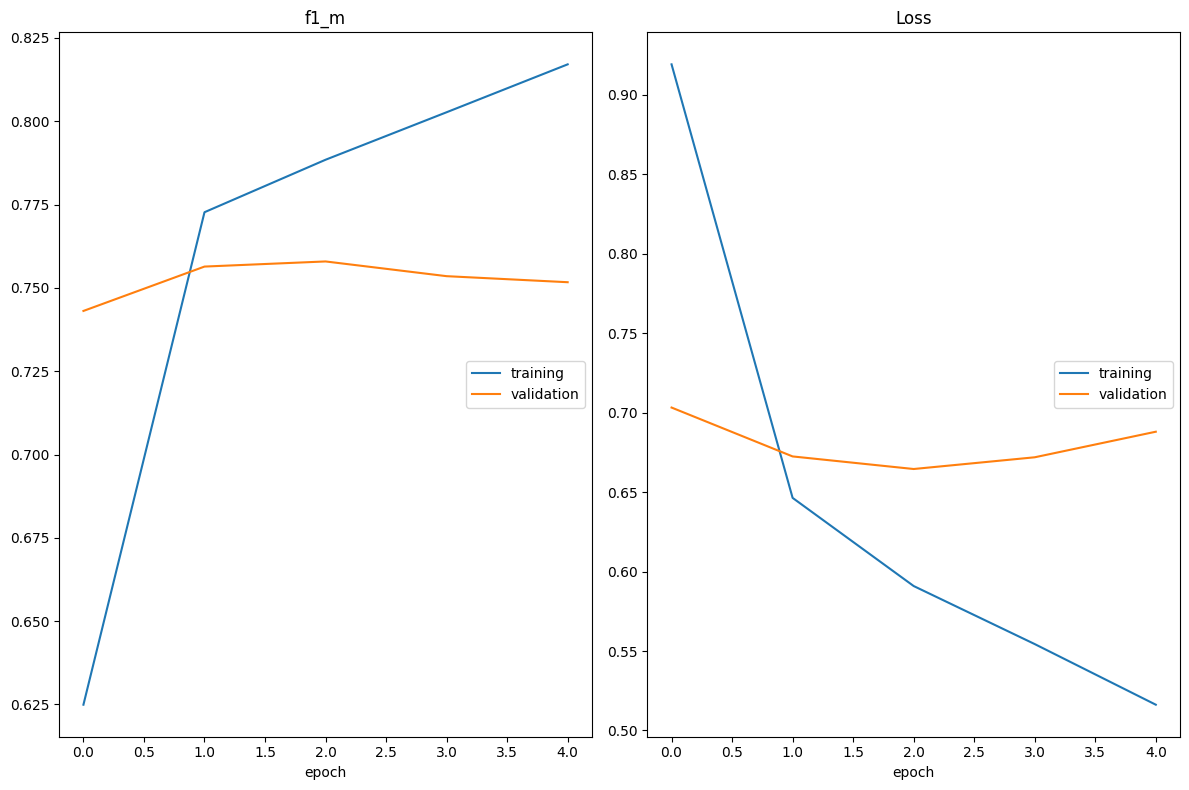

f1_m
	training         	 (min:    0.625, max:    0.817, cur:    0.817)
	validation       	 (min:    0.743, max:    0.758, cur:    0.752)
Loss
	training         	 (min:    0.516, max:    0.919, cur:    0.516)
	validation       	 (min:    0.665, max:    0.703, cur:    0.688)


In [31]:
batch_size = 64
epochs = 5

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesCallback()])

In [32]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

159/159 [==============================] - 7s 44ms/step - loss: 0.6880 - f1_m: 0.7517

Оценка теста: 0.6880121231079102
Оценка точности модели: 0.7517091035842896


In [310]:
X_val = test['review']
X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(X_val, maxlen=maxSequenceLength)

In [311]:
model.predict(X_val)

array([[5.44459373e-03, 2.13085882e-09, 7.46562145e-10, ...,
        8.54059046e-10, 5.10278085e-07, 9.94554877e-01],
       [1.03581893e-04, 9.25284880e-08, 2.77650845e-08, ...,
        2.55081795e-05, 5.50358763e-08, 9.99866486e-01],
       [1.18411763e-05, 2.42162656e-07, 2.71989185e-11, ...,
        6.54162662e-08, 6.43162079e-10, 9.99987364e-01],
       ...,
       [4.53357245e-07, 1.72610115e-02, 1.08610521e-09, ...,
        6.39665245e-08, 2.96590571e-07, 9.82737720e-01],
       [1.27463264e-03, 1.61543325e-01, 7.12474701e-08, ...,
        8.27289164e-01, 1.81755040e-05, 1.21582514e-06],
       [1.50236988e-03, 1.10758185e-08, 9.69508807e-10, ...,
        2.43307957e-10, 1.49568068e-05, 9.98310447e-01]], dtype=float32)

In [309]:
res = np.argmax(model.predict(X_val), axis=-1)

UnimplementedError:  Cast string to float is not supported
	 [[node sequential_25/Cast (defined at <ipython-input-308-4d3d2ef1d7bf>:1) ]] [Op:__inference_predict_function_255292]

Function call stack:
predict_function


In [ ]:
test['lstm'] = res

In [288]:
test['target'] = res
test[['review_id', 'target']].to_csv('predict_lstm.csv', index=False)

In [ ]:
model.save('../models/lstm_model')